In [ ]:
!pip install datasets

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

In [ ]:
encoded_input = tokenizer("Do not meddle in the affairs of wizards, for they are subtle and quick to anger.")
print(encoded_input)

In [ ]:
tokenizer.decode(encoded_input["input_ids"])

In [ ]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]

encoded_batch = tokenizer(batch_sentences)
print(encoded_batch)

In [ ]:
encoded_batch = tokenizer(batch_sentences,padding=True)
print(encoded_batch)

In [ ]:
encoded_batch = tokenizer(batch_sentences,padding=True,truncation=True)
print(encoded_batch)

In [ ]:
batch_sentences = [
    "But what about second breakfast?",
    "Don't think he knows about second breakfast, Pip.",
    "What about elevensies?",
]
encoded_input = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")
print(encoded_input)

In [20]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:100]")

In [21]:
dataset[0]["image"]
dataset[0].keys()

dict_keys(['image', 'label'])

In [7]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [23]:
from torchvision.transforms import RandomResizedCrop, ColorJitter, Compose

print(image_processor.size)

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ColorJitter(brightness=0.5, hue=0.5)])

{'height': 224, 'width': 224}


In [24]:
def transforms(examples):
    images = [_transforms(img.convert("RGB")) for img in examples["image"]]
    examples["pixel_values"] = image_processor(images, do_resize=False, return_tensors="pt")["pixel_values"]
    return examples


In [25]:
dataset.set_transform(transforms)

In [26]:
dataset[0].keys()

dict_keys(['image', 'label', 'pixel_values'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.4431373].


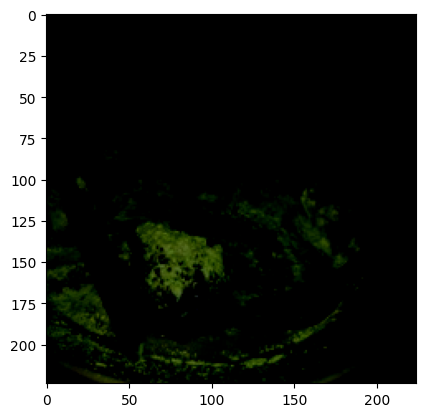

In [30]:
import numpy as np
import matplotlib.pyplot as plt

img = dataset[0]["pixel_values"]
plt.imshow(img.permute(1, 2, 0))

In [31]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.encode(pixel_values,return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch